<a href="https://colab.research.google.com/github/Ash100/CADD_Project/blob/main/Exploratory_Data_Analysis_Part13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exploratory Data Analysis with Compound Dataset**
This tutorial notebook is designed to teach you, that how can you perform exploratory data analysis on your compound data, you are using for Drug Designing and machine learning.
My name **Dr. Ashfaq Ahmad** you can follow me on Youtube Channel [**Bioinformatics Insights**](https://www.youtube.com/channel/UC2Z_WaqTjbvXGGQNpIF9nAg)

## **Important Read**

Nucleic Acids Res. 2019; 47(D1):D930-D940. doi: 10.1093/nar/gky1075

 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4489283/

## **Installation job**


In [ ]:
! pip install chembl_webresource_client

In [2]:
import pandas as pd
from chembl_webresource_client.new_client import new_client

### **Picking your desired Target from ChEMBL**

Here we will launch search for the desired target protein or enzyme. To overcome any possibility of a potential mistake, it is highly advised also to confirm you ChEMBL ID from the direct database (ChEMBL) search.

In [ ]:
# As an example I will use P2Y purinoceptor 1 protein (UniProt Accession P47900)
target = new_client.target
target_query = target.search('CHEMBL4315')
targets = pd.DataFrame.from_dict(target_query)
targets

**Note.** If you are not clear, how to select data from ChEMBL, I recommend a watch [**recommend video**](https://youtu.be/JHrzoeTH8_k).

### **Selection and Retrieval Bioactivity data**

In case you are hit with multiple data lines, then you need to choose the desired data, using the index number below in the cell.

In [4]:
selected_target = targets.target_chembl_id[0]
selected_target

'CHEMBL4315'

If you carefully look to the data columns, you will find variety of variable. Here we are interested to perform analysis for Antagonist, therefore, I will go with IC50 column. Please read about IC50 values incase you are not aware.

In [ ]:
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")
df = pd.DataFrame.from_dict(res)
df

Lets play with the above data that contains too many rows and columns. By running the below command, you will only see the first four data lines.

In [ ]:
df.head(4)

The standard_type column in the data contains IC50. If you want to validate, so better to search for the unique features in the standard_type

In [ ]:
df.standard_type.unique()

Now we are now in a position to save our data in a CSV file. I will use the name Bioactivity_data.csv

In [8]:
#saving data into csv file with out index column
df.to_csv('data_1.csv', index=False)

How our data looks like, take a look if you want to

In [ ]:
! head data_1.csv

### **Treating Missing Data**

There comes a possibility that some of the ChEMBL compounds may contain missing value for the **standared_value (IC50)** and **canonical_smiles**. Therefore, we need to remove such entries from the data.

In [9]:
df2 = df[df.standard_value.notna()]

In [ ]:
df2 = df[df.canonical_smiles.notna()]
df2

In [ ]:
len(df2.canonical_smiles.unique())

In [ ]:
df2_nr = df2.drop_duplicates(['canonical_smiles'])
df2_nr

### **Data Preprocessing**

We will be interested to keep record of the three columns, **ChEMBL_id**, **canonical_smiles**, and **standard_value**.

In [ ]:
selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df3 = df2_nr[selection]
df3

Now we need to save data frame or the df3 to the CSV file.

In [14]:
df3.to_csv('data_2.csv', index=False)

### **Labeling compounds to different categories**

Here we will need to categorize these compounds into different catergories, based on the IC50 value or **standard_value**. For the purpose, we will classify three groups, **Active**, **Inactive**, **Intermediate**. Compounds with IC50 value less than 1000 nM will be considered active drugs, those greater than 10,000 nM will be considered inactive and IC50 value in greater than 1000 and below 10,000 will be termed as intermediate.

In [15]:
df4 = pd.read_csv('data_2.csv')

In [16]:
bioactivity_threshold = []
for i in df4.standard_value:
  if float(i) >= 10000:
    bioactivity_threshold.append("inactive")
  elif float(i) <= 1000:
    bioactivity_threshold.append("active")
  else:
    bioactivity_threshold.append("intermediate")

In [ ]:
bioactivity_class = pd.Series(bioactivity_threshold, name='class')
df5 = pd.concat([df4, bioactivity_class], axis=1)
df5

Now we need to save the above dataframe or df5 to the CSV file.

In [18]:
df5.to_csv('data_3.csv', index=False)

In [ ]:
df5

Here, we are going to drop the smiles column

In [ ]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [20]:
import pandas as pd

In [21]:
df_no_smiles = df5.drop(columns='canonical_smiles')

In [22]:
smiles = []

for i in df.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [ ]:
df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_clean_smiles

### **Calculations of Lipinski Descriptors**
What are Lipinski rules or Descriptors?

A Pfizer scientist, Christopher Lipinski, designed a bunch of rules in evaluating a chemical compound for **druglikeness**. Lipinski analyzed these rules after studying vaste number of FDA-approved drugs in the formulation. In Simple terms, druglikeness is primarily based on the drug Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski rules are normally known as  **Rule-of-Five** or **Lipinski's Rule**.

The Lipinski's Rule states,
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10

In [ ]:
!pip install rdkit

In [26]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

### **Calculation of Lipinski Descriptors**

In [27]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

In [ ]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_lipinski

Now we have two different dfs, one is df5 and another one we have just created. we are going to combine it

In [29]:
df_combined = pd.concat([df5,df_lipinski], axis=1)

In [ ]:
df_combined

### **Convert IC50 to pIC50**
The **IC50** values are normally too much diverse therefore we need to the data to be more uniformly distributed, and for the reason we will convert **IC50** to the negative logarithmic scale which is essentially **-log10(IC50)** or **pIC50**

Next we will use the custom function pIC50() which will accept a DataFrame as input and will output,
* Take the IC50 values from the ``standard_value`` column and converts it from nM (nanoMolar) to M (molar) concentration by multiplying the value by 10$^{-9}$
* Take the molar value and apply -log10
* Delete the ``standard_value`` column and create a new ``pIC50`` column.

Point to note: These calculations will also normalize the data and values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.

In [31]:
import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)

    return x

In [ ]:
df_combined.standard_value.describe()

In [ ]:
-np.log10( (10**-9)* 100000000 )

In [ ]:
-np.log10( (10**-9)* 10000000000 )

In [35]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)

    return x

In [ ]:
import pandas as pd

# Normalization function
def norm_value(input_df):
    # Normalize the 'standard_value' column
    norm = (input_df['standard_value'] - input_df['standard_value'].min()) / (input_df['standard_value'].max() - input_df['standard_value'].min())
    input_df['standard_value_norm'] = norm
    x = input_df.drop('standard_value', axis=1)
    return x

# Assuming df_combined is already loaded
df_norm = norm_value(df_combined)
print(df_norm)

In [ ]:
df_norm

In [ ]:
df_norm.standard_value_norm.describe()

In [ ]:
import pandas as pd

# Function to calculate pIC50 values
def pIC50(input_df):
    # Assuming we are calculating pIC50 using the normalized values
    input_df['pIC50'] = -np.log10(input_df['standard_value_norm'] * 1e-9)  # Example transformation
    return input_df

# Assuming df_norm is already created
df_final = pIC50(df_norm)
print(df_final)

In [ ]:
df_final

In [ ]:
df_final.pIC50.describe()

We are going to save this new data file

In [42]:
df_final.to_csv('data_4.csv')

### **Optional- Removal of the intermediate class from the whole data**
Here we are going to drop the compounds with intermediate bioactivity. We will drop them because we want to compare the active and inactive class.

In [ ]:
df_2class = df_final[df_final['class'] != 'intermediate']
df_2class

In [45]:
df_2class.to_csv('data_5.csv')

### **Lets Perform Exploratory Data Analysis OR Chemical Space Analysis through Lipinski descriptors**

In [51]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

1. **Analysing the Frequency Plot of the Two (Active & Inactive) Classes**

Text(0, 0.5, 'Frequency')

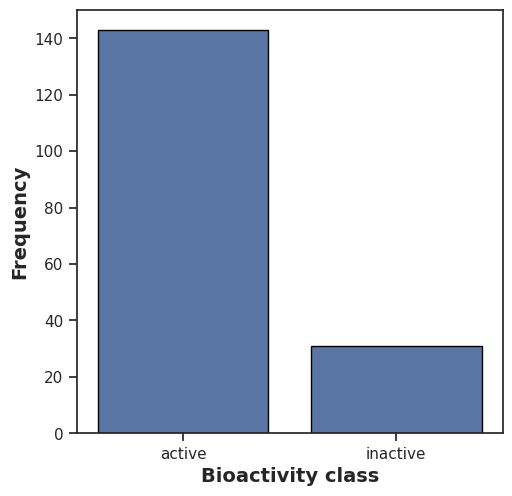

In [52]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

In [ ]:
plt.savefig('plot_bioactivity_class.pdf')

### **Scatter plot of Molecular Weight (MW) versus LogP (Solubility)**

It can be seen that the 2 bioactivity classes are not taking or spanning a kind of similar chemical spaces as evident by the scatter plot of MW vs LogP.
In below function, **x** and **y** are for the legends on these axis. **data** means, data to be plotted. **hue** represents the coloring scheme, and here we are interested to be based on the bioactivity class. **size** are for the sphere size and will be proportional to the pIC50 value. sphere **edges** will be black and transperancy threshould or *alpha* of the picture is 0.7. You can adjusted if required.

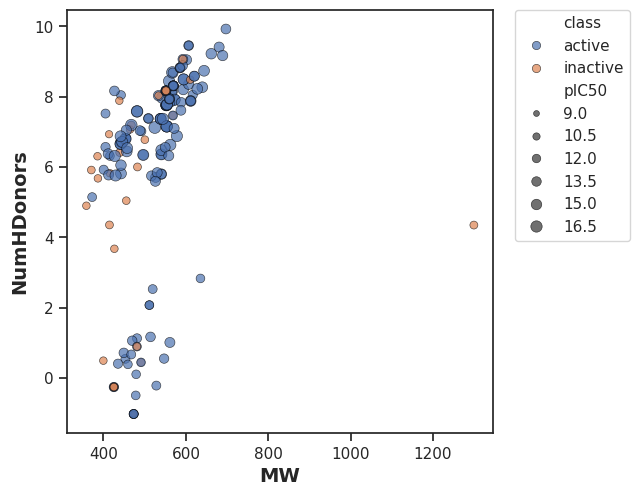

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure df_2class does not contain non-finite values
df_2class = df_2class.replace([np.inf, -np.inf], np.nan).dropna(subset=['MW', 'NumHDonors', 'pIC50'])

# Plotting
plt.figure(figsize=(5.5, 5.5))
sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

# Save the plot
plt.savefig('plot_MW_vs_LogP.pdf')
plt.show()

**Lets do some Calculations with Box Plot as well**



**pIC50**

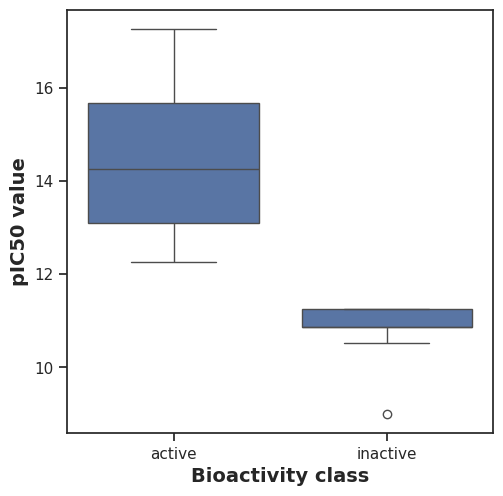

In [58]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_IC50.pdf')

Learn How to Predict pIC50 for unknown compounds with Artificial Neural Networks [**Here**](https://youtu.be/9FGWX2whI1Q).

### **Statistical analysis | Mann-Whitney U Test**

In [59]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_2class[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_2class[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'

  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [60]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,4402.0,2.985358e-18,0.05,Different distribution (reject H0)


**Molecular Weight (MW)**

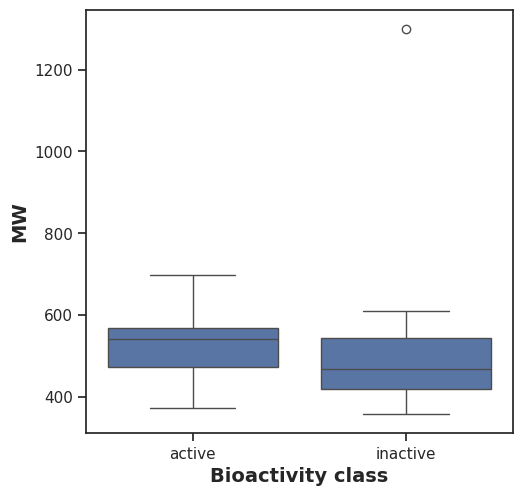

In [61]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [62]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,3074.5,0.000548,0.05,Different distribution (reject H0)


#### **LogP or Solubility**

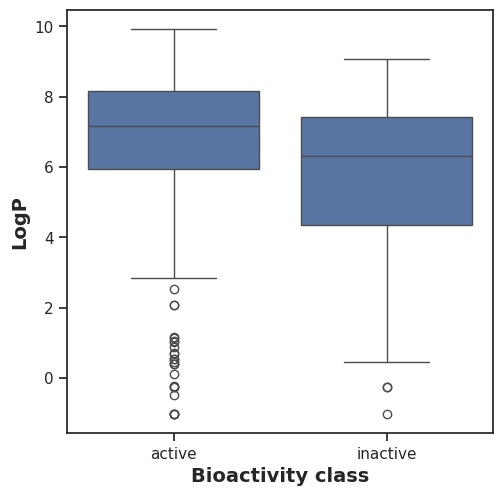

In [63]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

In [64]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,2762.5,0.026365,0.05,Different distribution (reject H0)


#### **NumHDonors or H-bond Donor**

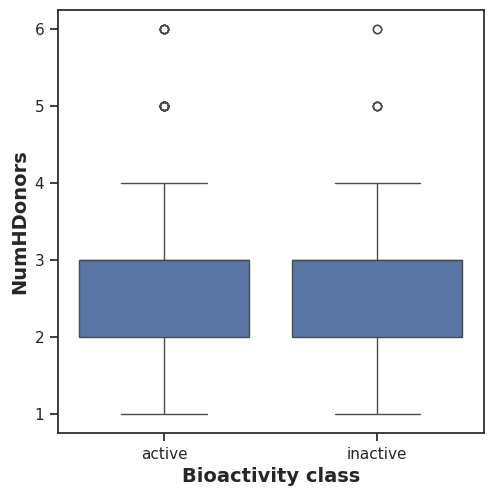

In [65]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

In [66]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,2152.0,0.838594,0.05,Same distribution (fail to reject H0)


#### **NumHAcceptors or H-bond Acceptor**

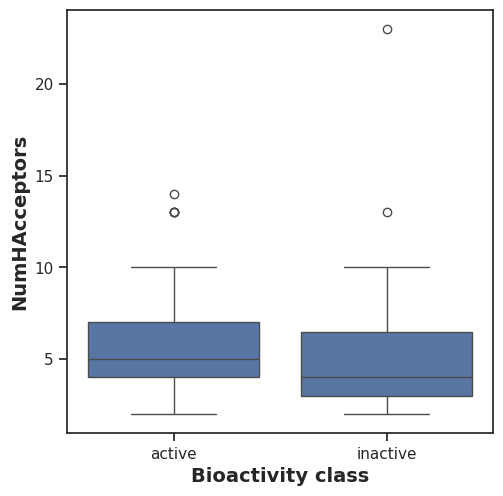

In [67]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [68]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,2510.0,0.214419,0.05,Same distribution (fail to reject H0)


### **Interpretation of the Statistical Results**

In the final part we have run Mannwhitney U test. The Mann-Whitney U test is used to compare differences between two independent groups when the dependent variable is either ordinal or continuous, but not normally distributed.

The p-value is a probability that measures the evidence against the null hypothesis. A smaller p-value provides stronger evidence against the null hypothesis.

#### **Download these results as a Zip files**

In [ ]:
! zip -r Exploratory_data_analysis.zip . -i *.csv *.pdf

##**Congratulation! That was Cool, Isn't?**

If you happy for your time, Please provide your Support in the Form of a Subscription on Youtube Channel**

[**Bioinformatics Insights**](https://www.youtube.com/channel/UC2Z_WaqTjbvXGGQNpIF9nAg)

Follow [**WhatsApp Channel**](https://whatsapp.com/channel/0029VajkwkdCHDydS6Y2lM36) for further updates, research services, and courses.